## Project | Featurization Model Selection and Tuning

In [50]:
import pandas as pd
import numpy as np
House=pd.read_csv('kc_house_data.csv')

In [51]:
# Visualising the data
House.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [52]:
# Checking for null values
House.isnull().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [53]:
# Feature 2 Date, seems to be the valuation date (The date on which the price of the property was assessed).
# Hence creating a new feature called valution year and month
House['Val_YYYYMM']=pd.to_numeric(House['date'].str[:6])

In [54]:
#Correlation Coffecient
from scipy.stats.stats import pearsonr
for Column in House._get_numeric_data():
    corr, p_value = pearsonr(House[Column], House['price'])
    print(Column,': ',corr)

id :  -0.01676219661444511
price :  1.0
bedrooms :  0.3083495981456383
bathrooms :  0.5251375054139619
sqft_living :  0.7020350546118
sqft_lot :  0.08966086058710011
floors :  0.2567938875507184
waterfront :  0.2663694340306021
view :  0.3972934882945043
condition :  0.036361789128997554
grade :  0.6674342560202371
sqft_above :  0.6055672983560783
sqft_basement :  0.32381602071198395
yr_built :  0.054011531494792715
yr_renovated :  0.12643379344089295
zipcode :  -0.05320285429832561
lat :  0.3070034799952186
long :  0.021626241039305872
sqft_living15 :  0.585378903579568
sqft_lot15 :  0.08244715251948598
Val_YYYYMM :  0.0030612302107294455


In [55]:
X=House.drop(['id','date','price'],axis=1)
Y=House['price']

# Feature scaling
from scipy.stats import zscore
X_Scaled = X.apply(zscore)

In [56]:
# Dict to store the ranks
ranks = {}
# Function to scale the feature ranks and store it in the ranks dict
from sklearn.preprocessing import MinMaxScaler
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

#### Finding feature importance using different models

In [57]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor

Colnames = X_Scaled.columns

# RFE - Recursive feature elimination
LR=LinearRegression()
rfe = RFE(LR, n_features_to_select=1, verbose =3 )
fit = rfe.fit(X_Scaled, Y)
ranks["RFE"] = ranking(list(map(float, fit.ranking_)), Colnames, order=-1)

# Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(X_Scaled,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), Colnames)

# Lasso Regression
lasso = Lasso(alpha=.05)
lasso.fit(X_Scaled, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), Colnames)

# Random Forest Regressor
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(X_Scaled, Y)
ranks["RF"] = ranking(np.abs(rf.feature_importances_), Colnames)

Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.1s


building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.5s finished


#### Feature importance comparison between different models

In [58]:
MeanDF = pd.DataFrame.from_dict(ranks)
MeanDF['feature'] = MeanDF.index
MeanDF['mean'] = MeanDF.mean(axis=1)
MeanDF=MeanDF.sort_values(by=['mean'], ascending=False)
MeanDF

,RFE,LinReg,Lasso,RF,feature,mean
sqft_living,1.00,0.71,1.00,0.86,sqft_living,0.8925
grade,0.94,1.00,0.42,1.00,grade,0.8400
lat,0.83,0.73,0.31,0.51,lat,0.5950
yr_built,0.89,0.67,0.28,0.08,yr_built,0.4800
sqft_above,0.56,0.66,0.32,0.06,sqft_above,0.4000
waterfront,0.78,0.43,0.18,0.09,waterfront,0.3700
view,0.72,0.33,0.14,0.03,view,0.3050
bathrooms,0.67,0.26,0.11,0.01,bathrooms,0.2625
bedrooms,0.61,0.27,0.11,0.00,bedrooms,0.2475
sqft_basement,0.50,0.21,0.22,0.01,sqft_basement,0.2350


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


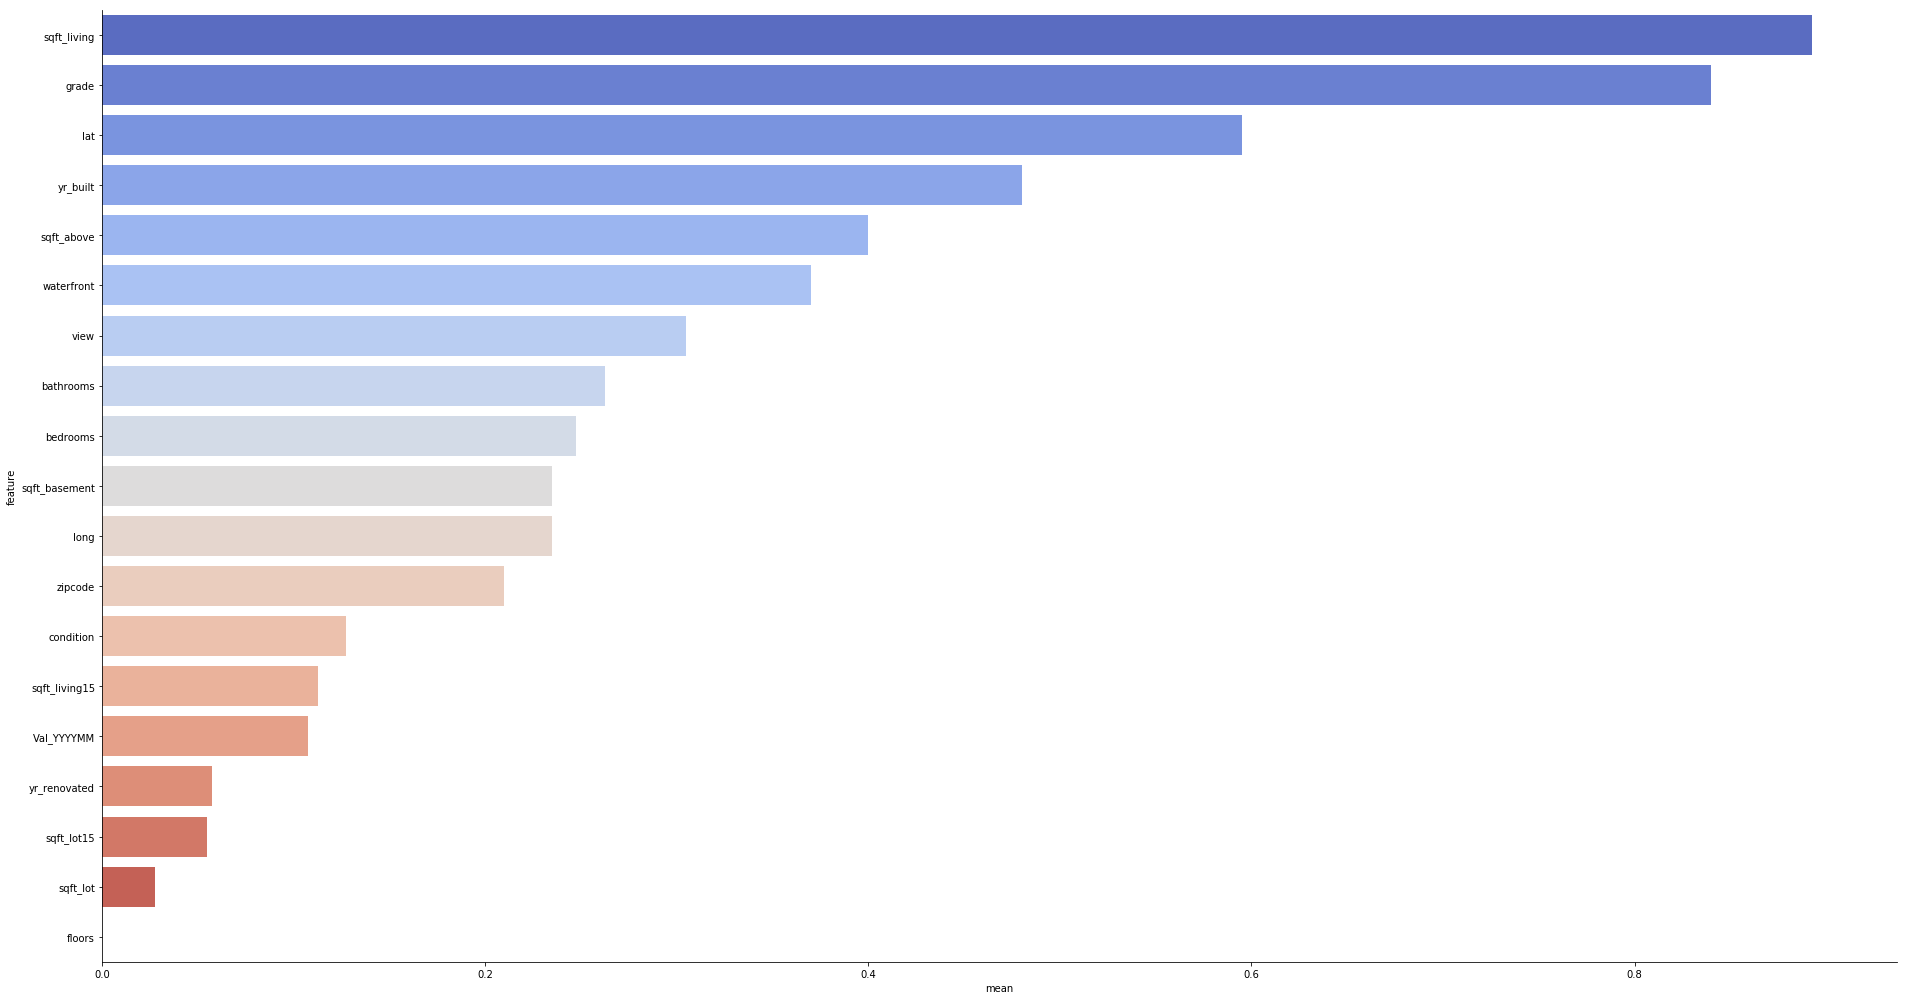

In [59]:
import seaborn as sns
# Fator plot to visualise the mean calculation
sns.factorplot(x="mean", y="feature", data = MeanDF, kind="bar", size=14, aspect=1.9, palette='coolwarm')

In [60]:
List=MeanDF.index[MeanDF['mean']>= MeanDF['mean'].median()].tolist()

print("Critical features for prediction",List)

Critical features for prediction ['sqft_living', 'grade', 'lat', 'yr_built', 'sqft_above', 'waterfront', 'view', 'bathrooms', 'bedrooms', 'sqft_basement', 'long']


In [61]:
X=X_Scaled[List]

from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.30, random_state=101)
LR=LinearRegression().fit(X_train,y_train)
print('Simple Linear Model Test Accuracy:',LR.score(X_test,y_test))

y_pred = LR.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE:',rmse)

Simple Linear Model Test Accuracy: 0.7002808699658182
RMSE: 205044.07220413152


In [62]:
from sklearn.model_selection import GridSearchCV,cross_val_score

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y,test_size=0.3,random_state =1 )

model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model,parameters, cv=10)
grid.fit(X_train, y_train)
print ("r2 Value:", grid.best_score_)

r2 Value: 0.6956811091150493


In [63]:
# Cross validation for average score
model = LinearRegression()
Score=cross_val_score(model, X, Y, cv=10)
print("Average score:" , np.mean(Score))


Average score: 0.6879362507407667


#### Converting independent feature into polynomial features and performing Simple Linear Regression

In [65]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
X_Train_poly = poly_reg.fit_transform(X_train)
X_Test_poly = poly_reg.fit_transform(X_test)


In [66]:
pol_reg = LinearRegression()
pol_reg.fit(X_Train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [68]:
print('Polynomial Regression Test value:',pol_reg.score(X_Test_poly,y_test))

y_pred = pol_reg.predict(X_Test_poly)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE:',rmse)

Polynomial Regression Test value: 0.7886155830704806
RMSE: 181633.7899848705


Inference: Features were selected based on the insights provided by different models. Lower scores on Gridsearch (Simple Linear model) suggests, the data points are sparse
Hence the score was 68% with high Root Mean square error values.

Coverting features to Polynomial features has helped to scores to go up by 78% and significantly reducing the RSME error values.